### Buoy Data
* Connecting to buoy data via csv url
* Used pandas dataframe to stage data
* Buoy 45026
* Location: Stevensville, MI
* cooridinates: 41.982 N 86.619 W (41°58'55" N 86°37'10" W)

In [1]:
import pandas as pd
import numpy as np
import re #importing regex for string parsing

In [66]:
# Connection
import pandas as pd
import numpy as np
import re #importing regex for string parsing
pd.set_option('display.max_columns', None)

#reading website data as csv
buoy_data = pd.read_csv(
    'https://www.ndbc.noaa.gov/data/realtime2/45026.txt',
    sep = r'\s+',
    header = 0,
    index_col = None
)

#dataframe to drop first record since first record represents units of measurements for fields within dataset
df = buoy_data.iloc[1:]
df1 = pd.DataFrame(df)

#### Manipulation

In [68]:
# renaming fields
df1.rename(columns = {
    '#YY':'Year','MM':'Month','DD':'Day','hh':'Hour','mm':'Minute','WDIR':'Wind_Dir','WSPD':'Wind_Speed','GST':'Wind_Gust','WVHT':'Wave_Height',
    'DPD':'Dominant_Wave_Prd','APD':'Average_Wave_Prd','MWD':'Dominant_Wave_Dir','PRES':'Sea_Level_Pres','ATMP':'Air_Temperature',
    'WTMP':'Surface_Water_Temperature','DEWP':'Dew_Point_Temp','VIS':'Station_Visibility','PTDY':'Pressure_Tendency'
},inplace=True)

# Find and Replace all 'MM' values as null as this is likely a nullable value from source data - from observation
df1.replace(to_replace='MM',value = 0,inplace=True)

# appending datetime stamp field to existing df
df1.insert(19,'Timestamp',(df1['Year'] + '-' + df1['Month'] + '-' + df1['Day']+ ' ' + df1['Hour'] + ':' + df1['Minute']).astype('str'),True)
df1.insert(20,'yyyy-mm-dd',(df1['Year'] + '-' + df1['Month'] + '-' + df1['Day']).astype('str'))

#grouping and sorting dataframe by timestamp field| ensure most current record at top of file
df1.sort_values(by = 'Timestamp',ascending = False, inplace = True)

#############################################
#conversions
df1.insert(14,'Air_Temp_Deg_F',((df1['Air_Temperature'].astype('float')*(9/5))+32)) #converting air temp to fahrenheit
#df1.insert(15,'Surface_Water_Temp',((df1['WTMP'].astype('float')*(9/5))+32)) # converting surface water temp to fahrenheit
df1.insert(16,'Surface_Water_Temp_Deg_F',((df1['Surface_Water_Temperature'].astype('float')*(9/5))+32)) # converting surface water temp to fahrenheit
df1.insert(18,'DewPoint_Temp_Deg_F',((df1['Dew_Point_Temp'].astype('float')*(9/5))+32)) # converting dewpoint temp to fahrenheit
df1.insert(7,'Wind_Speed_MPH',(df1['Wind_Speed'].astype('float')*2.237)) # converting windspeed to MPH
df1.insert(9,'Wind_Gust_MPH',(df1['Wind_Gust'].astype('float')*2.237)) # converting wind gust to MPH
df1.insert(11,'Wave_Height_FT',(df1['Wave_Height'].astype('float')*3.281)) # converting wave height to feet


###########################################
# appending condition for Wind and Wave Direction values
# compass direction dictionary
a = {
    'min_val':[0,11.25,33.75,56.25,78.75,101.25,123.75,146.25,168.75,191.25,213.75,236.25,258.75,281.25,303.75,326.25,348.75],
    'max_val':[11.24,33.74,56.24,78.24,101.24,123.74,146.24,168.74,191.24,213.74,236.24,258.74,281.24,303.74,326.24,348.74,360.00],
    'direction':['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW','N']
}
# changing to df
df_a = pd.DataFrame(a)

# function to apply compass direction to wave_direction data
def get_corresponding_value(i):
    for _, row in df_a.iterrows():
        if row['min_val'] <=i<=row['max_val']:
            return row['direction']
    return None

#appended values to df1 for wave direction
df1.insert(15,'Wave_Direction', df1['Dominant_Wave_Dir'].astype('float').apply(get_corresponding_value))
#appending values to df1 for wind direction
df1.insert(6,'Wind_Direction', df1['Wind_Dir'].astype('float').apply(get_corresponding_value))

C:\Users\errol\AppData\Local\Temp\ipykernel_12932\3316097591.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1.replace(to_replace='MM',value = 0,inplace=True)


#### Output Testing

In [70]:
df1.head(5)

,Year,Month,Day,Hour,Minute,Wind_Dir,Wind_Direction,Wind_Speed,Wind_Speed_MPH,Wind_Gust,Wind_Gust_MPH,Wave_Height,Wave_Height_FT,Dominant_Wave_Prd,Average_Wave_Prd,Dominant_Wave_Dir,Wave_Direction,Sea_Level_Pres,Air_Temperature,Air_Temp_Deg_F,Surface_Water_Temperature,Surface_Water_Temp_Deg_F,Dew_Point_Temp,DewPoint_Temp_Deg_F,Station_Visibility,Pressure_Tendency,TIDE,Timestamp,yyyy-mm-dd
1,2024,11,24,18,50,140,SE,6.0,13.422,8.0,17.896,0.4,1.3124,0,0,120,ESE,1013.2,7.9,46.22,9.7,49.46,3.2,37.76,0,0,0,2024-11-24 18:50,2024-11-24
2,2024,11,24,18,40,140,SE,6.0,13.422,9.0,20.133,0.4,1.3124,0,0,174,S,1013.2,7.8,46.04,9.7,49.46,3.3,37.94,0,0,0,2024-11-24 18:40,2024-11-24
3,2024,11,24,18,30,130,SE,6.0,13.422,8.0,17.896,0.4,1.3124,3,0,248,WSW,1013.4,7.7,45.86,9.7,49.46,3.4,38.12,0,0,0,2024-11-24 18:30,2024-11-24
4,2024,11,24,18,20,140,SE,6.0,13.422,8.0,17.896,0.4,1.3124,0,0,171,S,1013.6,7.7,45.86,9.7,49.46,3.1,37.58,0,0,0,2024-11-24 18:20,2024-11-24
5,2024,11,24,18,10,150,SSE,6.0,13.422,7.0,15.659,0.4,1.3124,3,0,251,WSW,1013.9,7.4,45.32,9.7,49.46,3.1,37.58,0,0,0,2024-11-24 18:10,2024-11-24


### Determining Correletion between Wind, Wave, and Air temps to influence water surface temp

In [196]:
df2 = df1[[
    'Wind_Dir',
    'Wind_Speed_MPH',
    'Wind_Gust_MPH',
    'Dominant_Wave_Dir',
    'Air_Temp_Deg_F',
    'DewPoint_Temp_Deg_F',
    'Wave_Height_FT',
    'Surface_Water_Temp_Deg_F'
]]
corr = df2.corr(method='pearson')
#corr output
df2.corr(method='pearson')

,Wind_Dir,Wind_Speed_MPH,Wind_Gust_MPH,Dominant_Wave_Dir,Air_Temp_Deg_F,DewPoint_Temp_Deg_F,Wave_Height_FT,Surface_Water_Temp_Deg_F
Wind_Dir,1.000000,0.212165,0.215407,0.188368,0.010912,0.040840,0.305451,-0.220388
Wind_Speed_MPH,0.212165,1.000000,0.977574,-0.052559,-0.070466,0.054711,0.650871,-0.187605
Wind_Gust_MPH,0.215407,0.977574,1.000000,-0.005550,-0.098279,0.024460,0.694880,-0.193679
Dominant_Wave_Dir,0.188368,-0.052559,-0.005550,1.000000,-0.217584,-0.202524,0.440486,0.021363
Air_Temp_Deg_F,0.010912,-0.070466,-0.098279,-0.217584,1.000000,0.832819,-0.319481,0.592269
DewPoint_Temp_Deg_F,0.040840,0.054711,0.024460,-0.202524,0.832819,1.000000,-0.200433,0.340817
Wave_Height_FT,0.305451,0.650871,0.694880,0.440486,-0.319481,-0.200433,1.000000,-0.192639
Surface_Water_Temp_Deg_F,-0.220388,-0.187605,-0.193679,0.021363,0.592269,0.340817,-0.192639,1.000000


#### Linear Graph

<Axes: xlabel='Surface_Water_Temp_Deg_F', ylabel='Air_Temp_Deg_F'>

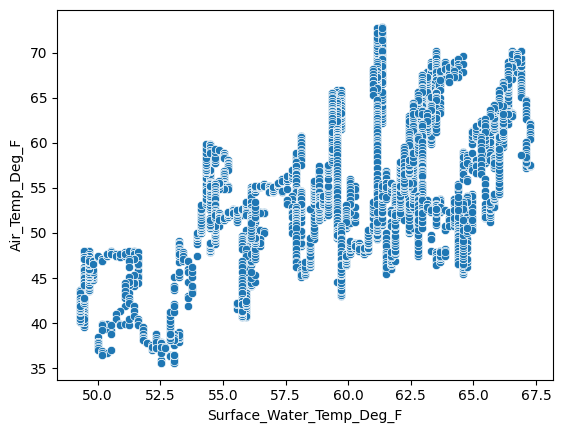

In [186]:
# Entire lookback
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(
    x=df2['Surface_Water_Temp_Deg_F'],
    y=df2['Air_Temp_Deg_F']
    ,data=corr)

### Notes
---

Appears that surface water temperature is more influenced by air temperature, which has the strongest correlation,
followed by the dewpoint temperature and then the dominant wave direction (the point of highest wave energy direction that wave is traveling from);
I wonder if this can mean, when surface water is warmer, if there is a slight influence when wind direction is from shore (where wind direction is from the east)....does dominant wind direction ever come from the shore? I'll need to check this out.  Could see if I can pull stationary thermostat temps maybe at local weather station to correlte with the buoy ir temp

#### CSV Output

In [33]:
# writing output to csv file 
df1.to_csv(r'C:/Users/errol/Documents/test_output3.csv')